<a href="https://colab.research.google.com/github/stevenpl98/bluebikes/blob/master/BlueBikes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setup**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#For Colab -- DO NOT RUN LOCALLY
import os
#Install Java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Set JAVA_HOME path variable in Linux
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version


#Install Spark
#download Spark file
!wget -q http://apache.osuosl.org/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz 
#extract the file
!tar xf spark-3.0.0-bin-hadoop3.2.tgz
#Set SPARK-HOME path variable in Linux
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


#install findspark package
!pip install -q findspark

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode
openjdk version "1.8.0_252"
OpenJDK Runtime Environment (build 1.8.0_252-8u252-b09-1~18.04-b09)
OpenJDK 64-Bit Server VM (build 25.252-b09, mixed mode)


In [ ]:
import findspark
findspark.init()

In [ ]:
# create entry points to spark
try:
    sc.stop()
except:
    pass
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
conf = SparkConf().setAppName("bluebikes").setMaster("local[*]")#local[2]
sc=SparkContext(conf = conf)
#spark = SparkSession(sparkContext=sc)

**Add Title Here**

In [ ]:
test = sc.textFile('./drive/My Drive/Big Data/data/Bikes Data/Years/2014.csv')
#test = sc.textFile('./drive/My Drive/Big Data/data/Bikes Data/Years/hubway_Trips_2011.csv')
test.take(3)

['tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,postal code',
 '366,2020-03-01 00:01:09.0060,2020-03-01 00:07:15.2360,9,Commonwealth Ave at Agganis Way,42.35169201885972,-71.11903488636017,446,700 Commonwealth Ave.,42.349609453330594,-71.10391523698127,5566,Customer,1969.0,0.0,',
 '367,2020-03-01 00:01:10.9500,2020-03-01 00:07:18.1970,9,Commonwealth Ave at Agganis Way,42.35169201885972,-71.11903488636017,446,700 Commonwealth Ave.,42.349609453330594,-71.10391523698127,4113,Customer,1969.0,0.0,']

In [ ]:
#2019-11-01 00:00:00.2770
test = datetime.strptime('2019-11-01 00:00:00.2770','%Y-%m-%d %H:%M:%S.%f')
print(test)

NameError: ignored

In [ ]:
mappedrdd = rdd.map(lambda x:x.split(','))

test1 = mappedrdd.map(lambda x: x[1])

temp = test1.first()
test2 = test1.filter(lambda x: x != temp)

test3 = test2.map(lambda x: x[5:7]).distinct()

out = test3.collect()

print(out)

NameError: ignored

In [ ]:
#12/31/2014 23:58
import time
start = time.time()
from datetime import datetime

def try_parsing_date(text):
    for fmt in ('%Y-%m-%d %H:%M:%S', '%Y-%m-%d %H:%M:%S.%f','%m/%d/%Y %H:%M'):
        try:
            return datetime.strptime(text, fmt)
        except ValueError:
            pass
    raise ValueError('String "'+ text +'" could not convert to Datetime')

In [ ]:
#Extracting Years, then going to begin separating by month


rdd = sc.textFile('./drive/My Drive/Big Data/data/Bikes Data/cleaned_data.csv')
mappedrdd = rdd.map(lambda x:x.split(','))

#cleanedrdd = mappedrdd.filter(lambda x: (x[0] != 'Duration' or x[0] != 'tripduration') )
mappedrdd.take(3)
#dates = mappedrdd.map(lambda x: (x[1], x[6]))#.filter(lambda x: (x != 'Start date')).filter(lambda x: (x != 'startdate'))
#header = temp.first()

#dates = temp.filter(lambda x: x[0] != '')#.filter(lambda x: '2014' in x)
#dates = temp.filter(lambda x: (x != 'starttime'))

#dates.take(3)




[['203810',
  '8/23/2012 7:42',
  '8/23/2012 7:45',
  'C32001',
  'Roxbury Crossing Station',
  'B32002',
  'Ruggles Station / Columbus Ave.',
  'B00297',
  'Member',
  '2120',
  'Male'],
 ['229342',
  '8/23/2012 7:41',
  '8/23/2012 7:45',
  'A32010',
  'South Station - 700 Atlantic Ave.',
  'D32008',
  'Rowes Wharf - Atlantic Ave',
  'B00167',
  'Member',
  '1760',
  'Male'],
 ['550914',
  '8/23/2012 7:41',
  '8/23/2012 7:50',
  'C32008',
  'Boylston at Fairfield',
  'C32006',
  'Washington St. at Rutland St.',
  'B00001',
  'Member',
  '2199',
  'Male']]

In [ ]:
def set_age_group(current,val):
    try:
      year = int(current) - int(val)
      if year < 18:
        return('under 18')
      elif year < 25:
        return('18 - 24')
      elif year < 40:
        return('25 - 39')
      elif year < 60:
        return('40 - 59')
      else:
        return('60+')
    except:
      return('error')

I need to go back and separate out the 2020, because birth year is on a different column for whatever reason

In [ ]:
years = ['2011','2012','2013','2014','2020']

dates = mappedrdd.map(lambda x: (x[1], x[-2], x[-3]) )

cleaned = dates.filter(lambda x: not any(val in x[0] for val in years)).filter(lambda x: x[1] != '\\N' and x[1] != '')

In [ ]:
age_groups = cleaned.map(lambda x: (try_parsing_date(x[0]),x[1][0:4]))
age_groups.take(3)

[(datetime.datetime(2015, 12, 1, 0, 1, 52), '1995'),
 (datetime.datetime(2015, 12, 1, 0, 5, 30), '1983'),
 (datetime.datetime(2015, 12, 1, 0, 7, 46), '1995')]

In [ ]:
prep_reduce = age_groups.map(lambda x: (( x[0].year, x[0].month, set_age_group(x[0].year ,x[1])), 1)).filter(lambda x: x[1] != 'error')
vals = prep_reduce.reduceByKey(lambda x, y: x + y)

In [ ]:
def add_zero_value(rider_list):
    if len(rider_list) != 5:
      rider_list.append(0)
    return(rider_list) 

In [ ]:
#combine = vals.sortBy(lambda x: x[0]).collect()

combine = vals.map(lambda x: ((x[0][0], x[0][1]), [(x[0][2],x[1])]))

prep = combine.reduceByKey(lambda x, y: x + y).map(lambda x: (x[0], [item[1] for item in sorted(x[1])]))

out = prep.map(lambda x: (x[0], add_zero_value(x[1]))).sortBy(lambda x: x[0]).collect()

#out.take(3)

#out = combine.reduceByKey(lambda x, y: x + y).map(lambda k, v: (k, sorted(v, key=lambda x: x[1], reverse=True))).collect()

#for item in out:
#  print(item)


In [ ]:
#test field
import numpy as np
percent = np.array([sum(item[1]) for item in out])
print(percent)

[  7586   3858  10614  45019 106817 110297 127968 118056 119120 107743
  78167  43892  11495  13776  35651  67602 100721 129754 128396 136439
 134183 117949  88636  44946  18437  16211  29348  77322 105602 130856
 135489 156249 142078 141444  96839  52952  39393  59320  58429  98095
 178674 205146 242652 235813 235954 199900 121283  81884 139572 160768
 204536 333044 445718 547518 316585 674162 725654 610378 381114 184198]


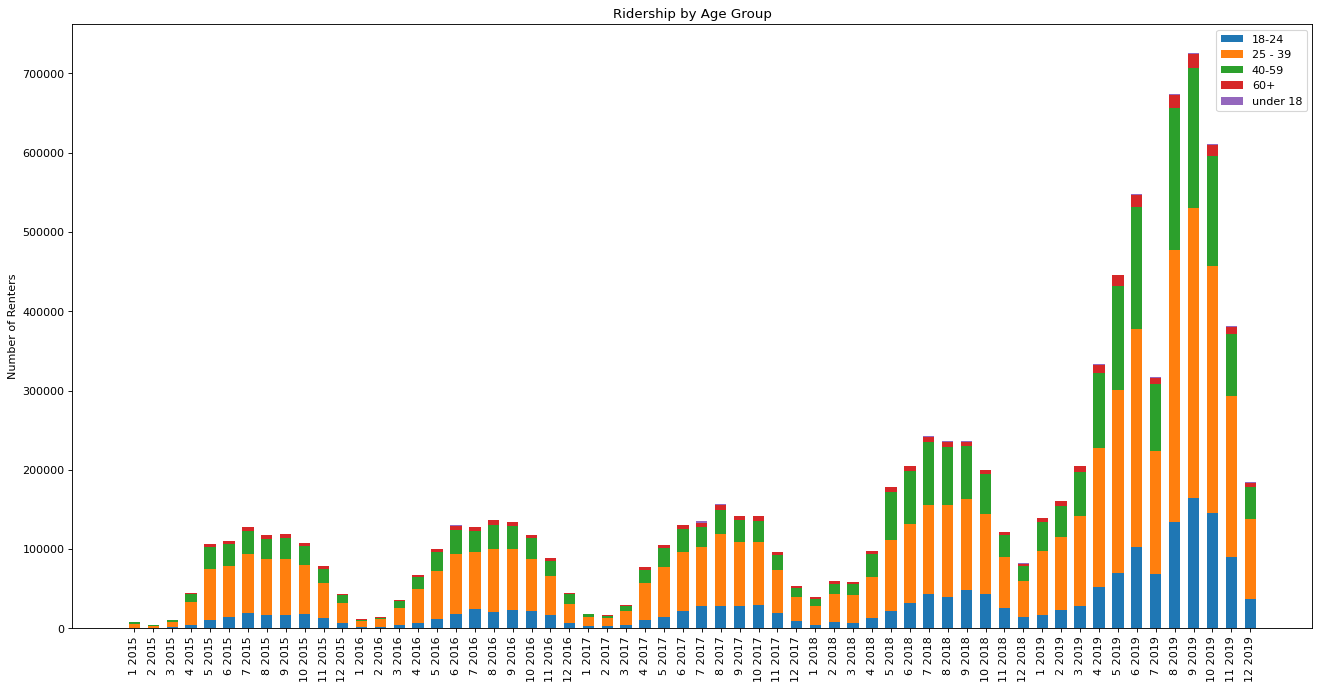

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(num=None, figsize=(20, 10), dpi=80)

labels = [str(item[0][1]) + ' ' + str(item[0][0]) for item in out]

one = np.array([item[1][0] for item in out])
two = np.array([item[1][1] for item in out])
three = np.array([item[1][2] for item in out])
four = np.array([item[1][3] for item in out])
five = np.array([item[1][4] for item in out])

width = .6

ax.bar(labels, one, width,  label='18-24')
ax.bar(labels, two, width,  bottom=one,label='25 - 39')
ax.bar(labels, three, width,  bottom=two+one,label='40-59')
ax.bar(labels, four, width,  bottom=one+two+three,label='60+')
ax.bar(labels, five, width,  bottom=one + two + three + four,label='under 18')


ax.set_ylabel('Number of Renters')
ax.set_title('Ridership by Age Group')
ax.legend()
plt.xticks(rotation='vertical')

plt.show()

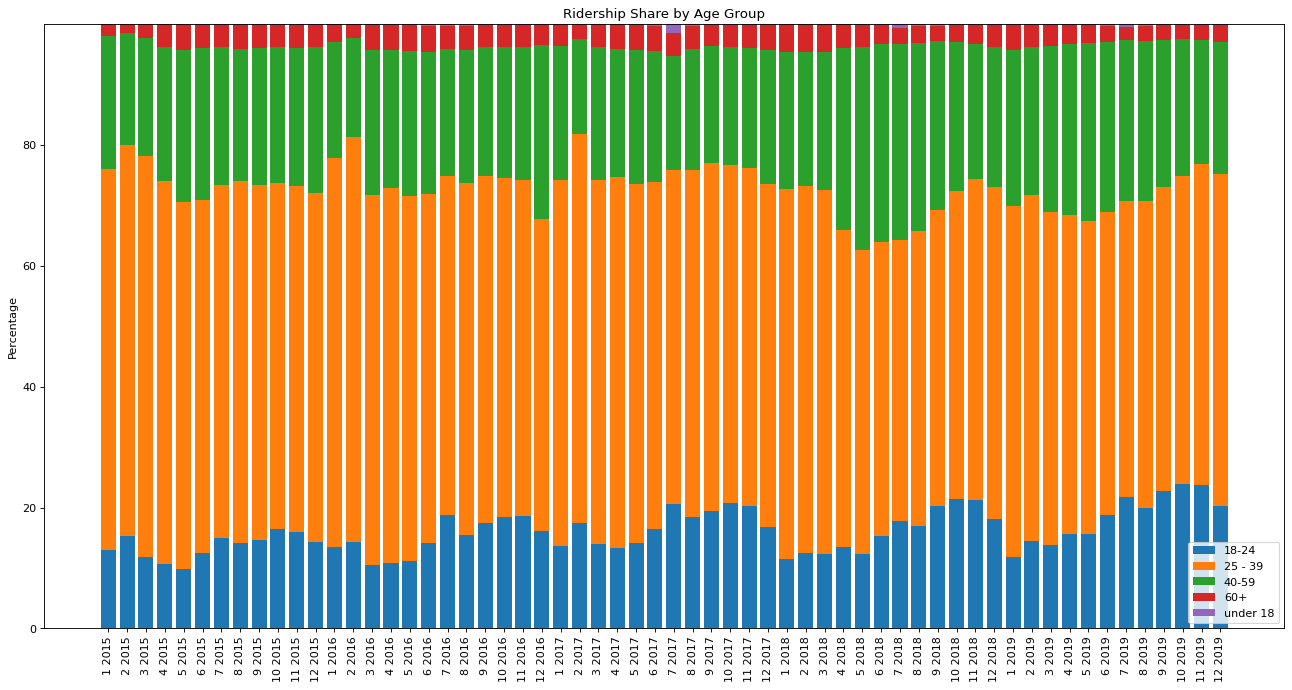

In [ ]:
fig, ax = plt.subplots(num=None, figsize=(20, 10), dpi=80)

labels = [str(item[0][1]) + ' ' + str(item[0][0]) for item in out]



one_percent = np.round_(([float(x) for x in one] / percent) * 100, 5)
two_percent = np.round_(([float(x) for x in two] / percent) * 100, 5)
three_percent = np.round_(([float(x) for x in three] / percent) * 100, 5)
four_percent = np.round_(([float(x) for x in four] / percent) * 100, 5)
five_percent = np.round_(([float(x) for x in five] / percent) * 100, 5)

width = .8

ax.bar(labels, one_percent, width,  label='18-24')
ax.bar(labels, two_percent, width,  bottom=one_percent,label='25 - 39')
ax.bar(labels, three_percent, width,  bottom=two_percent + one_percent,label='40-59')
ax.bar(labels, four_percent, width,  bottom=two_percent + one_percent + three_percent,label='60+')
ax.bar(labels, five_percent, width,  bottom=two_percent + one_percent + three_percent + four_percent,label='under 18')


ax.set_ylabel('Percentage')
ax.set_title('Ridership Share by Age Group')
ax.legend()
plt.xticks(rotation='vertical')

plt.show()

In [ ]:
def RemoveHeader(rdd):
  header = rdd.first()
  data = rdd.filter(lambda x: x != header) 
  return (data)

**Cleaning RDDS**

In [ ]:
# Clean rdds

rdd2011 = rdd = sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/hubway_Trips_2011.csv')
rdd2012 = rdd = sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/hubway_Trips_2012.csv')
rdd2013 = rdd = sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/hubway_Trips_2013.csv')
rdd2014 = rdd = sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/2014.csv')
rdd2015 = rdd = sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/2015.csv')
rdd2016 = rdd = sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/2016.csv')
rdd2017 = rdd = sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/2017.csv')
rdd2018 = rdd = sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/2018.csv')
rdd2019 = rdd = sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/2019.csv')
rdd2020 = rdd = sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/2020.csv')

cleaned_rdd = sc.union([RemoveHeader(rdd2011),RemoveHeader(rdd2012),RemoveHeader(rdd2013),RemoveHeader(rdd2014),RemoveHeader(rdd2015),
                       RemoveHeader(rdd2016),RemoveHeader(rdd2017),RemoveHeader(rdd2018),RemoveHeader(rdd2019),RemoveHeader(rdd2020)])
cleaned_rdd.saveAsTextFile('/content/drive/My Drive/Big Data/data/Bikes Data/cleaned_data.csv')


Py4JJavaError: ignored

In [ ]:
import pandas as pd
import time
start = time.time()
#out = pd.DataFrame(cleaned_rdd.collect())
#out = cleaned_rdd.collect()
#print(str(time.time() - start))
#out.to_csv('/content/drive/My Drive/Big Data/data/Bikes Data/cleaned_data.csv')

**Month vs Month Difference Throughout Years**

In [ ]:
# Clean year rdds
rdd11 =  RemoveHeader(sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/hubway_Trips_2011.csv')).map(lambda x:x.split(','))
rdd12 =  RemoveHeader(sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/hubway_Trips_2012.csv')).map(lambda x:x.split(','))
rdd13 =  RemoveHeader(sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/hubway_Trips_2013.csv')).map(lambda x:x.split(','))
rdd14 =  RemoveHeader(sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/2014.csv')).map(lambda x:x.split(','))
rdd15 =  RemoveHeader(sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/2015.csv')).map(lambda x:x.split(','))
rdd16 =  RemoveHeader(sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/2016.csv')).map(lambda x:x.split(','))
rdd17 =  RemoveHeader(sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/2017.csv')).map(lambda x:x.split(','))
rdd18 =  RemoveHeader(sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/2018.csv')).map(lambda x:x.split(','))
rdd19 =  RemoveHeader(sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/2019.csv')).map(lambda x:x.split(','))
rdd20 =  RemoveHeader(sc.textFile('/content/drive/My Drive/Big Data/data/Bikes Data/Years/2020.csv')).map(lambda x:x.split(','))

In [ ]:
# Month Collection formatting
trips11 = rdd11.map(lambda x: x[1][0:2])
trips12 = rdd12.map(lambda x: x[1][0:2])
trips13 = rdd13.map(lambda x: x[1][0:2])
trips14 = rdd14.map(lambda x: x[1][0:2])
trips15 = rdd15.map(lambda x: x[1][5:7])
trips16 = rdd16.map(lambda x: x[1][5:7])
trips17 = rdd17.map(lambda x: x[1][5:7])
trips18 = rdd18.map(lambda x: x[1][5:7])
trips19 = rdd19.map(lambda x: x[1][5:7])
trips20 = rdd20.map(lambda x: x[1][5:7])

In [ ]:
# Month collections
t11 = trips11.collect()
t12 = trips12.collect()
t13 = trips13.collect()
t14 = trips14.collect()
t15 = trips15.collect()
t16 = trips16.collect()
t17 = trips17.collect()
t18 = trips18.collect()
t19 = trips19.collect()
t20 = trips20.collect()

In [83]:
# Gets trip numbers per month for all months in a year
def tripsPerMonth(collection, year):
  trips = pd.DataFrame(collection, columns=["x"]).groupby('x').size().to_dict()

  # Add missing months to 2011-2013
  if year == 2011:
    missing = {
      'January': 0,
      'February': 0,
      'March': 0,
      'April': 0,
      'May': 0,
      'June': 0,
      'December': 0
    }
    trips.update(missing)
  elif(year == 2012):
    missing = {
      'January': 0,
      'February': 0,
      'December': 0
    }
    trips.update(missing)
  elif(year == 2013):
    missing = {
      'January': 0,
      'February': 0,
      'March': 0
    }
    trips.update(missing)
  return trips

In [90]:
from collections import OrderedDict

# Format months as example ahead: '1/' or '01' to January and order them
def formatMonth(d):
  changes = {
      '1/':'January',
      '01':'January',
      'January': 'January',
      '2/':'February',
      '02':'February',
      'February':'February',
      '3/':'March',
      '03':'March',
      'March':'March',
      '4/':'April',
      '04':'April',
      'April':'April',
      '5/':'May',
      '05':'May',
      'May':'May',
      '6/':'June',
      '06':'June',
      'June':'June',
      '7/':'July',
      '07':'July',
      'July':'July',
      '8/':'August',
      '08':'August',
      'August':'August',
      '9/':'September',
      '09':'September',
      'September':'September',
      '10':'October',
      'October':'October',
      '11':'November',
      'November':'November',
      '12':'December',
      'December':'December'
  }
  # Re-format months so they are strings
  d2 = dict((changes[key], value) for (key, value) in d.items())

  # Re-order months since some were unordered
  keyorder = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
  d3 = OrderedDict(sorted(d2.items(), key= lambda i: keyorder.index(i[0])))

  return d3

In [78]:
# Add appropriate year to each month
def formatYear(d, year):
  changes = {
      'January':'January {}'.format(year),
      'February':'February {}'.format(year),
      'March':'March {}'.format(year),
      'April':'April {}'.format(year),
      'May':'May {}'.format(year),
      'June':'June {}'.format(year),
      'July':'July {}'.format(year),
      'August':'August {}'.format(year),
      'September':'September {}'.format(year),
      'October':'October {}'.format(year),
      'November':'November {}'.format(year),
      'December':'December {}'.format(year)
  }
  d2 = dict((changes[key], value) for (key, value) in d.items())

  return d2

In [93]:
trips2011 = formatYear(formatMonth(tripsPerMonth(t11, 2011)), 2011)
trips2012 = formatYear(formatMonth(tripsPerMonth(t12, 2012)), 2012)
trips2013 = formatYear(formatMonth(tripsPerMonth(t13, 2013)), 2013)
trips2014 = formatYear(formatMonth(tripsPerMonth(t14, 2014)), 2014)
trips2015 = formatYear(formatMonth(tripsPerMonth(t15, 2015)), 2015)
trips2016 = formatYear(formatMonth(tripsPerMonth(t16, 2016)), 2016)
trips2017 = formatYear(formatMonth(tripsPerMonth(t17, 2017)), 2017)
trips2018 = formatYear(formatMonth(tripsPerMonth(t18, 2018)), 2018)
trips2019 = formatYear(formatMonth(tripsPerMonth(t19, 2019)), 2019)
trips2020 = formatYear(formatMonth(tripsPerMonth(t20, 2020)), 2020)
print(trips2011)
print(trips2012)
print(trips2013)
print(trips2014)
print(trips2015)
print(trips2016)
print(trips2017)
print(trips2018)
print(trips2019)
print(trips2020)

{'January 2011': 0, 'February 2011': 0, 'March 2011': 0, 'April 2011': 0, 'May 2011': 0, 'June 2011': 0, 'July 2011': 2729, 'August 2011': 36233, 'September 2011': 40810, 'October 2011': 36326, 'November 2011': 24876, 'December 2011': 0}
{'January 2012': 0, 'February 2012': 0, 'March 2012': 14284, 'April 2012': 44142, 'May 2012': 53480, 'June 2012': 55636, 'July 2012': 70080, 'August 2012': 84842, 'September 2012': 83643, 'October 2012': 76868, 'November 2012': 47399, 'December 2012': 0}
{'January 2013': 0, 'February 2013': 0, 'March 2013': 0, 'April 2013': 63432, 'May 2013': 97682, 'June 2013': 108666, 'July 2013': 131259, 'August 2013': 147776, 'September 2013': 139228, 'October 2013': 138304, 'November 2013': 72378, 'December 2013': 8151}
{'January 2014': 6577, 'February 2014': 6967, 'March 2014': 11261, 'April 2014': 90942, 'May 2014': 141829, 'June 2014': 159897, 'July 2014': 173486, 'August 2014': 174668, 'September 2014': 169637, 'October 2014': 137732, 'November 2014': 77148, '

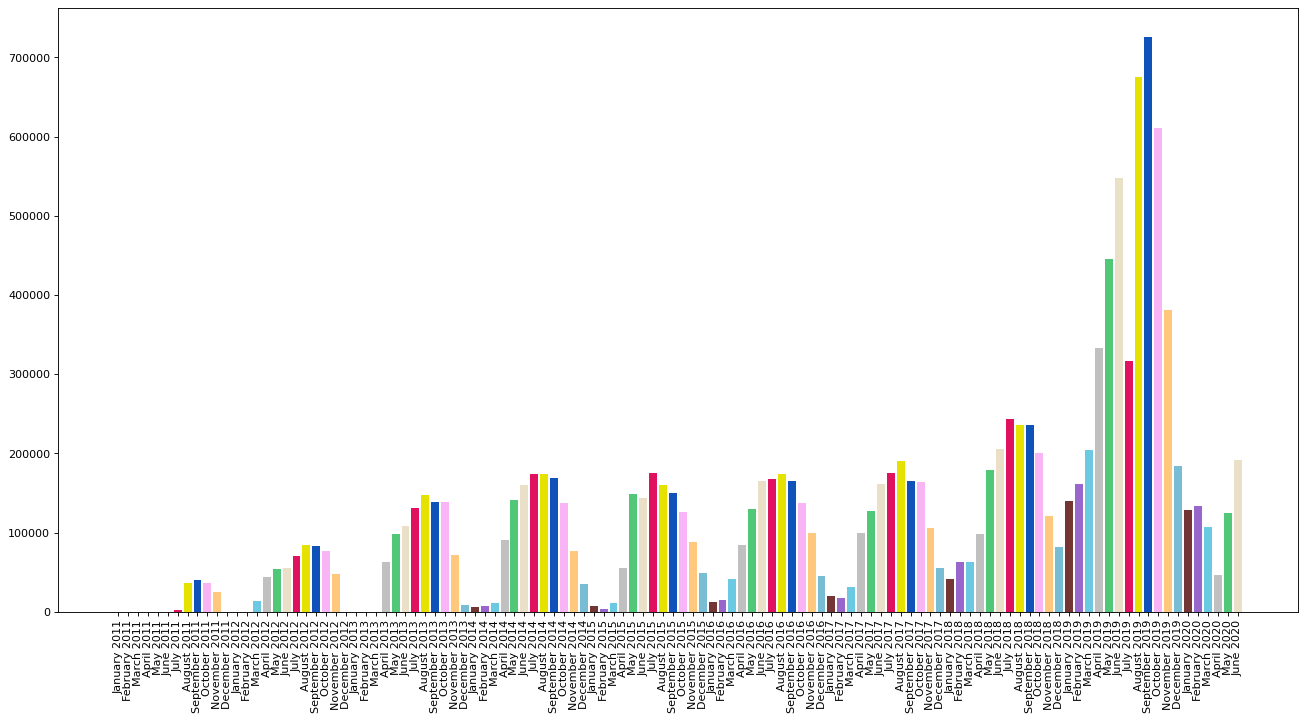

In [97]:
# Plotting monthly trip numbers across years

# Merge all years
trips = {**trips2011, **trips2012, **trips2013, **trips2014, **trips2015, **trips2016, **trips2017, **trips2018, **trips2019, **trips2020}
#print(trips)

fig, ax = plt.subplots(num=None, figsize=(20, 10), dpi=80)
# Birthstone colors to identify months
colors = ['#733635', '#9966cc', '#6bcae2', '#c0c0c0', '#50c878', '#eae0c8', '#e0115f', '#e6e200', '#0f52ba', '#f8b4f4', '#ffc87c', '#78bdd4']
plt.bar(range(len(trips)), list(trips.values()), align='center', orientation='vertical', color= colors)
plt.xticks(range(len(trips)), list(trips.keys()), rotation='vertical')

plt.show()

COVID-19 Effects

In [141]:
# Calculate percentage change
def dif(a, b):
  neg = ((b-a)/b)*100
  pos = 0
  if a < b:
    return '+{0:.2f}%'.format(pos)
  elif a > b:
    return '{0:.2f}%'.format(neg)

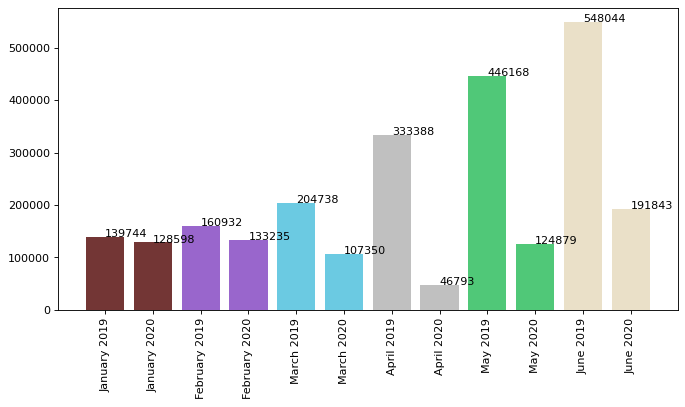

In [153]:
# Compare January through June in 2019 and 2020
fx = {
    'January 2019' : trips['January 2019'],
    'January 2020' : trips['January 2020'],
    'February 2019' : trips['February 2019'],
    'February 2020' : trips['February 2020'],
    'March 2019' : trips['March 2019'],
    'March 2020' : trips['March 2020'],
    'April 2019' : trips['April 2019'],
    'April 2020' : trips['April 2020'],
    'May 2019' : trips['May 2019'],
    'May 2020' : trips['May 2020'],
    'June 2019' : trips['June 2019'],
    'June 2020' : trips['June 2020']
}
fig, ax = plt.subplots(num=None, figsize=(10, 5), dpi=80)
# Birthstone colors to identify months
colors = ['#733635', '#733635', '#9966cc', '#9966cc', '#6bcae2', '#6bcae2', '#c0c0c0', '#c0c0c0', '#50c878', '#50c878', '#eae0c8', '#eae0c8']
plt.bar(range(len(fx)), list(fx.values()), align='center', orientation='vertical', color= colors)
plt.xticks(range(len(fx)), list(fx.keys()), rotation='vertical')

#diff = [dif(trips['January 2020'],trips['January 2019']), dif(trips['January 2020'],trips['January 2019']), dif(trips['January 2020'],trips['January 2019']), dif(trips['January 2020'],trips['January 2019']), dif(trips['January 2020'],trips['January 2019']), dif(trips['January 2020'],trips['January 2019'])]

for index,values in enumerate(list(fx.values())):
  plt.text(x= index , y= values , s= f"{values}" , fontdict= dict(fontsize=10))
plt.show()